## Stock Price Prediction

### Get data from yfinance

In [219]:
from pandas_datareader import data as pdr
from datetime import date
import yfinance as yf

yf.pdr_override()
import pandas as pd

ticker_list=["AAPL", "MSFT", "AMZN", "TSLA", "GOOGL"]
today = date.today()
# We can get data by our choice by giving days bracket
start_date= "2015-01-01"
end_date="2020-11-30"

files=[]
def getData(ticker):
    data = pdr.get_data_yahoo(ticker, start=start_date, end=today)
    # dataname= ticker+"_"+str(today)
    files.append((data,ticker))
    
for tik in ticker_list:
    getData(tik)
    
    



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [11]:
ticker = 'AAPL'
data = pdr.get_data_yahoo(ticker, start=start_date, end=today)
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-12-31,18.233213,19.121429,18.178572,19.006071,16.439852,659492400
2013-01-02,19.779285,19.821428,19.343929,19.608213,16.960695,560518000
2013-01-03,19.567142,19.631071,19.321428,19.360714,16.746613,352965200
2013-01-04,19.177500,19.236786,18.779642,18.821428,16.280138,594333600
2013-01-07,18.642857,18.903570,18.400000,18.710714,16.184374,484156400
...,...,...,...,...,...,...
2022-01-24,160.020004,162.300003,154.699997,161.619995,161.619995,162706700
2022-01-25,158.979996,162.759995,157.020004,159.779999,159.779999,115798400
2022-01-26,163.500000,164.389999,157.820007,159.690002,159.690002,108275300


### Setup firebase

In [ ]:
import firebase_admin

cred_obj = firebase_admin.credentials.Certificate('../../../fyp2022-stockpriceprediction-firebase-adminsdk-ku62m-f9ed330292.json')
fyp_app = firebase_admin.initialize_app(cred_obj, {
	'databaseURL':"https://fyp2022-stockpriceprediction-default-rtdb.asia-southeast1.firebasedatabase.app/",
	'storageBucket': 'fyp2022-stockpriceprediction.appspot.com'
	})

In [288]:
#https://cloud.google.com/storage/docs/downloading-objects#storage-download-object-python
from firebase_admin import storage
b = storage.bucket()
for ind, file in enumerate(b.list_blobs()):
    if(i<3):
        continue
    #print(file.download_to_filename('1.zip'))
    break

In [289]:
#https://stackoverflow.com/questions/53304517/how-to-retrieve-image-from-firebase-storage-using-python
file.generate_signed_url(timedelta(seconds=300), method='GET')

'https://storage.googleapis.com/fyp2022-stockpriceprediction.appspot.com/normalizers/TSLA/multi_lstm.pkl?Expires=1644330859&GoogleAccessId=firebase-adminsdk-ku62m%40fyp2022-stockpriceprediction.iam.gserviceaccount.com&Signature=lWzBiW7D3%2Foa%2Fi8ySOsUe8JGUzMFPS%2BYBDqrEDzLDM%2BBX1BcVtWKqZHDc7zQzc42QDlcYwP2Bivb7ohRhoDUFXvfgbUUQlZDZe3kxVvC45ZR8%2BcMcpuf6seUChm4l24K6ZGGS4m4b73OTAJo3lpvCIJL6BfkajvsqRxcxxYDtXJS7cAlHCuQTZh3IA0pMWbVXDaHeqKpcuO4dfWpbkFLHmin9jpwxTQZHX9ttbuPQ%2Fb791v%2FnlUyzT8aatWMYkh%2BzmWzjB4v94u3RmSbcxc3kvdVk4aHPE1YAYI3bNDBWd4nYEYQ9iR4OSDRC2%2B7Ll9qbEEP8cC9%2F0gQbMFRcHzLxg%3D%3D'

In [290]:
url = 'https://storage.googleapis.com/fyp2022-stockpriceprediction.appspot.com/normalizers/TSLA/multi_lstm.pkl?Expires=1644330859&GoogleAccessId=firebase-adminsdk-ku62m%40fyp2022-stockpriceprediction.iam.gserviceaccount.com&Signature=lWzBiW7D3%2Foa%2Fi8ySOsUe8JGUzMFPS%2BYBDqrEDzLDM%2BBX1BcVtWKqZHDc7zQzc42QDlcYwP2Bivb7ohRhoDUFXvfgbUUQlZDZe3kxVvC45ZR8%2BcMcpuf6seUChm4l24K6ZGGS4m4b73OTAJo3lpvCIJL6BfkajvsqRxcxxYDtXJS7cAlHCuQTZh3IA0pMWbVXDaHeqKpcuO4dfWpbkFLHmin9jpwxTQZHX9ttbuPQ%2Fb791v%2FnlUyzT8aatWMYkh%2BzmWzjB4v94u3RmSbcxc3kvdVk4aHPE1YAYI3bNDBWd4nYEYQ9iR4OSDRC2%2B7Ll9qbEEP8cC9%2F0gQbMFRcHzLxg%3D%3D'

In [ ]:
import cloudpickle as cp
from urllib.request import urlopen
loaded_pickle_object = cp.load(urlopen(url, 'rb')) 

In [292]:
pip install cloudpickle

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pyrebase

config = {
  "apiKey": firebase_admin.credentials.Certificate('../../../fyp2022-stockpriceprediction-firebase-adminsdk-ku62m-f9ed330292.json'),
  "authDomain": "fyp2022-stockpriceprediction.firebaseapp.com",
  'databaseURL':"https://fyp2022-stockpriceprediction-default-rtdb.asia-southeast1.firebasedatabase.app/",
  'storageBucket': 'fyp2022-stockpriceprediction.appspot.com',
  'serviceAccount': '../../../fyp2022-stockpriceprediction-firebase-adminsdk-ku62m-f9ed330292.json'
}

firebase = pyrebase.initialize_app(config)

In [ ]:
#https://stackoverflow.com/questions/48181580/download-all-files-from-firebase-storage-using-python
#https://github.com/thisbejim/Pyrebase#add-pyrebase-to-your-application
storage = firebase.storage()
for file in storage.child('models/AAPL/').list_files():
    with open(storage.child(file.name)) as f:
        word = f
    break

### Upload data into firebase


In [6]:
from firebase_admin import db
from datetime import datetime as dt

for file in files:
    
    tick = file[1]
    data = file[0]
    data['Ticker'] = tick
    
    #convert date index to string, as firebsae cant have datetime as an index
    data.index = data.index.strftime("%Y-%m-%d")
    
    #convert the dataframe to json/dictionary
    data_dict = data.to_dict(orient="index")
    
    #upload it to the database
    ref = db.reference("/data/"+tick)
    ref.set(data_dict)

### Get data from firebase database

In [105]:
from matplotlib import pyplot as plt
from firebase_admin import db
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
ref = db.reference("/data")
data = ref.get()

In [268]:
data_msft = {}
data_msft['MSFT'] = data['MSFT']

In [3]:
def get_all_file_paths(directory):
  
    # initializing empty file paths list
    file_paths = []
  
    # crawling through directory and subdirectories
    for root, directories, files in os.walk(directory):
        for fileName_model in files:
            # join the two strings in order to form the full filepath.
            filepath = os.path.join(root, fileName_model)
            file_paths.append(filepath)
  
    # returning all file paths
    return file_paths

### LSTM

In [272]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import math
from zipfile import ZipFile
import pickle
import os
from firebase_admin import storage
from sklearn.metrics import mean_squared_error
tf.debugging.set_log_device_placement(False)





try:
  # Specify an invalid GPU device
  #with tf.device('/device:GPU:2'):
  
#   with tf.device('/device:GPU:2'):
    for tick, stock_data in data_msft.items():
      print(tick)
      df = pd.DataFrame(stock_data).T
      df = df.reset_index()['Close']
      scaler = MinMaxScaler(feature_range=(0,1))
      df=scaler.fit_transform(np.array(df).reshape(-1,1))
      train_data = df[:int(0.9*len(df))]
      test_data = df[int(0.9*len(df)):]
      train_data = train_data.reshape(-1,1)
      test_data = test_data.reshape(-1,1)
      
      def create_dataset(dataset, time_step=1):
          dataX, dataY = [], []
          for i in range(len(dataset)-time_step-1):
              a = dataset[i:(i+time_step), 0]
              dataX.append(a)
              dataY.append(dataset[i + time_step, 0])
          return np.array(dataX), np.array(dataY)
      time_step = 60
      X_train, y_train = create_dataset(train_data, time_step)
      X_test, ytest = create_dataset(test_data, time_step)
      
      X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
      X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
      
      model=Sequential()
      model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
      model.add(LSTM(50,return_sequences=True))
      model.add(LSTM(50))
      model.add(Dense(1))
      model.compile(loss='mean_squared_error',optimizer='adam')
      history = model.fit(X_train, y_train,epochs=100, validation_split = 0.2)
      # break
      
      # calling function to get all file paths in the directory
      filepath_model = "../../../data/models/" + tick + "/lstm"
      model.save(filepath_model)
      file_paths = get_all_file_paths(filepath_model)

      
      #took help from this: https://www.geeksforgeeks.org/working-zip-files-python/
      with ZipFile(filepath_model + ".zip",'w') as zip:
              # writing each file one by one
              for file in file_paths:
                  zip.write(file)
      
      
      fileName_model = "lstm"
      bucket = storage.bucket()
    #   #upload models
      blob = bucket.blob("models/" + tick + "/" + fileName_model)
      blob.upload_from_filename(fileName_model+".zip")
      
      #upload normalizer
      filepath_normalizer = "../../../data/normalizers/" + tick + "/lstm.pkl"
      pickle.dump(scaler, open(filepath_normalizer, 'wb'))

      filename_normalizer = "lstm.pkl"
      blob = bucket.blob("normalizers/" + tick + "/" + filename_normalizer)
      blob.upload_from_filename(filepath_normalizer)
      
      # Opt : if you want to make public access from the URL
      #blob.make_public()
    # checking whether folder exists or not
      folder_path = filepath_model
      if os.path.exists(folder_path):

          # checking whether the folder is empty or not
          if len(os.listdir(folder_path)) == 0:
              # removing the file using the os.remove() method
              os.rmdir(folder_path)
          else:
              # messaging saying folder not empty
              print("Folder is not empty")
      else:
          # file not found message
          print("File not found in the directory")
        
except RuntimeError as e:
  print(e)

MSFT


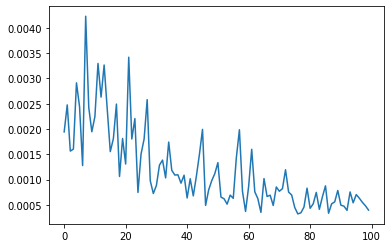

In [13]:
import matplotlib.pyplot as plt
plt.plot(history.history['val_loss'])

In [64]:
test_predict=model.predict(X_test)
test_predict=scaler.inverse_transform(test_predict)

ytest = scaler.inverse_transform(ytest.reshape(-1,1))
error = math.sqrt(mean_squared_error(ytest,test_predict))
error    

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Option

73.64311682215732

In [24]:
X_test

(127, 100, 1)

In [47]:
train_predict=model.predict(X_train)
train_predict=scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform(y_train.reshape(-1,1))
math.sqrt(mean_squared_error(y_train,train_predict))

3.0307830607276087

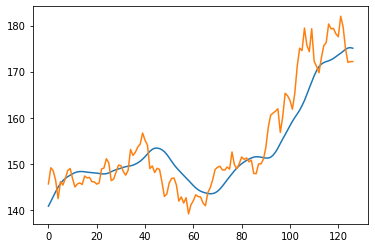

In [11]:
plt.plot(test_predict)
plt.plot(ytest)
plt.show()

In [26]:
# specifying the zip file name
file_name = "AAPL_model.zip"
  
# opening the zip file in READ mode
with ZipFile(file_name, 'r') as zip:
    # printing all the contents of the zip file
    zip.printdir()
  
    # extracting all the files
    print('Extracting all the files now...')
    zip.extractall()
    print('Done!')

File Name                                             Modified             Size
AAPL_model/keras_metadata.pb                   2022-01-12 19:16:08        17068
AAPL_model/saved_model.pb                      2022-01-12 19:16:08      2382689
AAPL_model/variables/variables.data-00000-of-00001 2022-01-12 19:16:08       618372
AAPL_model/variables/variables.index           2022-01-12 19:16:08         2731
Extracting all the files now...
Done!


In [110]:
#get the last 100 days and make a prediction
tick = 'AAPL'
def getTestData(ticker, start):
    data = pdr.get_data_yahoo(ticker, start=start, end=today)
    # dataname= ticker+"_"+str(today)
    return data[-100:]
    
   
   
from datetime import datetime, timedelta
start = d = today - timedelta(days=190)

df = getTestData(tick,start) 

#df = pd.DataFrame(stock_data).T
df = df.reset_index()['Close']
df=scaler.transform(np.array(df).reshape(-1,1))
test_data = df.reshape(-1,1)

import keras.models
model = keras.models.load_model(tick + '_model')
prediction = model.predict( np.array( [test_data,] )  )
scaler.inverse_transform(prediction)

[*********************100%***********************]  1 of 1 completed
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replic

array([[174.37128]], dtype=float32)

### Arima

In [73]:
from pmdarima.arima import auto_arima

stock_data = data['AAPL']
df = pd.DataFrame(stock_data).T

data = df.sort_index(ascending=True, axis=0)

train = data[:-2]
valid = data[-2:]

training = train['Close']
validation = valid['Close']

model = auto_arima(training, start_p=1, start_q=1,max_p=3, max_q=3, m=12,start_P=0, seasonal=True,d=1, D=1, trace=True,error_action='ignore',suppress_warnings=True)
model.fit(training)

forecast = model.predict(n_periods=len(valid))
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=1.47 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=8903.869, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=8357.856, Time=0.23 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.92 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=8891.064, Time=0.08 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=8009.664, Time=0.47 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=2.58 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.20 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=8023.083, Time=0.39 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=8011.656, Time=0.56 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=8011.619, Time=1.13 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=8009.624, Time=0.50 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=8358.974, Time=0.24 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=inf, Time=2.62 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=i

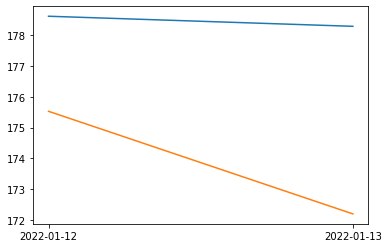

In [74]:
from matplotlib import pyplot as plt

plt.plot(forecast['Prediction'],label='Prediction')
plt.plot(valid['Close'], label='True value')
plt.show()

### Prophet

In [27]:
#importing prophet
from fbprophet import Prophet

stock_data = data['AAPL']
df = pd.DataFrame(stock_data).T

#creating dataframe
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])

for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

new_data['Date'] = pd.to_datetime(new_data.Date,format='%Y-%m-%d')
new_data.index = new_data['Date']

#preparing data
new_data.rename(columns={'Close': 'y', 'Date': 'ds'}, inplace=True)

#train and validation
train = new_data[:-10]
valid = new_data[-10:]

#fit the model
model = Prophet()
model.fit(train)

#predictions
close_prices = model.make_future_dataframe(periods=len(valid))
forecast = model.predict(close_prices)

ModuleNotFoundError: No module named 'fbprophet'

### Custom ANN (wih MA, H-L, O-C, etc.)

In [5]:
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import math
from zipfile import ZipFile
import pickle
import os
from firebase_admin import storage
from sklearn.metrics import mean_squared_error

In [6]:
data.keys()

dict_keys(['AAPL', 'AMZN', 'AVGO', 'CSCO', 'FB', 'GOOG', 'GOOGL', 'MSFT', 'NVDA', 'TSLA'])

In [7]:
histories = {}

def get_all_file_paths(directory):
  
    # initializing empty file paths list
    file_paths = []
  
    # crawling through directory and subdirectories
    for root, directories, files in os.walk(directory):
        for fileName_model in files:
            # join the two strings in order to form the full filepath.
            filepath = os.path.join(root, fileName_model)
            file_paths.append(filepath)
  
    # returning all file paths
    return file_paths
    
for tick in data.keys():
    stock_data = data[tick]
    df = pd.DataFrame(stock_data).T
    df['H-L'] = df['High'] - df['Low']
    df['O-C'] = df['Open'] - df['Close']
    df['7MA'] = df['Adj Close'].rolling(window=7).mean()
    df['14MA'] = df['Adj Close'].rolling(window=14).mean()
    df['21MA'] = df['Adj Close'].rolling(window=21).mean()
    df['7SD'] = df['Adj Close'].rolling(window=7).std()

    features = ['H-L','O-C','7MA','14MA','21MA','7SD','Volume','Close']
    df = df[features].apply(pd.to_numeric)
    df_final = df[20:].copy()
    df_final['Close'] = df_final['Close'].shift(1)

    features = ['H-L','O-C','7MA','14MA','21MA','7SD','Volume']
    #https://stackoverflow.com/questions/36926140/how-to-convert-numpy-arrays-to-standard-tensorflow-format
    X = np.asarray(df_final[1:][features], np.float32)
    Y = np.asarray(df_final[1:]['Close'], np.float32)

    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

    y_train = y_train.reshape(-1,1)
    scaler_x = MinMaxScaler().fit(X_train)
    scaler_y = MinMaxScaler().fit(y_train)

    X_train = scaler_x.transform(X_train)
    y_train = scaler_y.transform(y_train)
    # Defining the Input layer and FIRST hidden layer, both are same!
    model = Sequential()
    model.add(Dense(units=50, input_dim=7, kernel_initializer='normal', activation='relu'))
    
    # Defining the Second layer of the model
    # after the first layer we don't have to specify input_dim as keras configure it automatically
    model.add(Dense(units=25, kernel_initializer='normal', activation='tanh'))

    model.add(Dense(units=10, kernel_initializer='normal', activation='tanh'))
    
    # The output neuron is a single fully connected node 
    # Since we will be predicting a single number
    model.add(Dense(1, kernel_initializer='normal'))
    
    # Compiling the model
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    # Fitting the ANN to the Training set
    history = model.fit(X_train, y_train ,batch_size = 10, validation_split = 0.1, epochs = 180, verbose=1)

    histories[tick] = history

    filepath_model = "../../../data/models/" + tick + "/ann"
    model.save(filepath_model)
    file_paths = get_all_file_paths(filepath_model)

    
    #took help from this: https://www.geeksforgeeks.org/working-zip-files-python/
    with ZipFile(filepath_model + ".zip",'w') as zip:
            # writing each file one by one
            for file in file_paths:
                zip.write(file)
    
    
    fileName_model = "ann.zip"
    bucket = storage.bucket()
    #upload models
    blob = bucket.blob("models/" + tick + "/" + fileName_model)
    blob.upload_from_filename(filepath_model+".zip")
    
    #upload normalizer training data
    filepath_normalizer = "../../../data/normalizers/" + tick + "/ann_x.pkl"
    pickle.dump(scaler_x, open(filepath_normalizer, 'wb'))

    filename_normalizer = "ann_x.pkl"
    blob = bucket.blob("normalizers/" + tick + "/ann_x.pkl")
    blob.upload_from_filename(filepath_normalizer)

    #upload normalizer predicted value
    filepath_normalizer = "../../../data/normalizers/" + tick + "/ann_y.pkl"
    pickle.dump(scaler_y, open(filepath_normalizer, 'wb'))

    filename_normalizer = "ann_y.pkl"
    blob = bucket.blob("normalizers/" + tick + "/ann_y.pkl")
    blob.upload_from_filename(filepath_normalizer)

Epoch 1/180
163/163 [==============================] - 1s 3ms/step - loss: 0.0251 - val_loss: 6.2169e-04
Epoch 2/180
163/163 [==============================] - 0s 2ms/step - loss: 4.6893e-04 - val_loss: 5.1575e-04
Epoch 3/180
163/163 [==============================] - 0s 2ms/step - loss: 2.8317e-04 - val_loss: 5.5462e-04
Epoch 4/180
163/163 [==============================] - 0s 2ms/step - loss: 2.3498e-04 - val_loss: 2.5689e-04
Epoch 5/180
163/163 [==============================] - 0s 2ms/step - loss: 2.0628e-04 - val_loss: 2.4210e-04
Epoch 6/180
163/163 [==============================] - 0s 2ms/step - loss: 2.1313e-04 - val_loss: 2.4511e-04
Epoch 7/180
163/163 [==============================] - 0s 2ms/step - loss: 1.9792e-04 - val_loss: 2.5153e-04
Epoch 8/180
163/163 [==============================] - 0s 2ms/step - loss: 1.8857e-04 - val_loss: 1.8776e-04
Epoch 9/180
163/163 [==============================] - 0s 2ms/step - loss: 1.6274e-04 - val_loss: 2.9878e-04
Epoch 10/180
163/163 [=

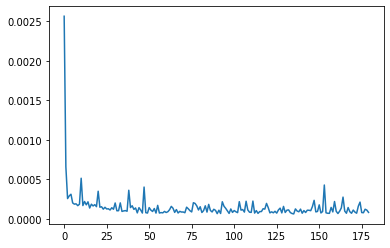

In [62]:
plt.plot(list(histories.values())[0].history['val_loss'])

In [74]:
from sklearn.metrics import mean_squared_error
y_test = y_test.reshape(-1,1)
y_test_transform = scaler_y.transform(y_test)
X_test = scaler_x.transform(X_test)
y_pred = model.predict(X_test)
mean_squared_error(y_test_transform, y_pred)
scaler_y.inverse_transform(y_pred)

0.000102086204

In [80]:
tick = 'NVDA'
import pandas_datareader as pdr
def getTestData(ticker, start):
    data = pdr.get_data_yahoo(ticker, start=start, end=today)
    # dataname= ticker+"_"+str(today)
    return data[-100:]
    
from datetime import date  
today = date.today()

from datetime import datetime, timedelta
start = d = today - timedelta(days=190)

df = getTestData(tick,start) 

In [81]:
df['H-L'] = df['High'] - df['Low']
df['O-C'] = df['Open'] - df['Close']
df['7MA'] = df['Adj Close'].rolling(window=7).mean()
df['14MA'] = df['Adj Close'].rolling(window=14).mean()
df['21MA'] = df['Adj Close'].rolling(window=21).mean()
df['7SD'] = df['Adj Close'].rolling(window=7).std()

test_data = np.asarray(df[-1:][features], np.float32)
test = scaler_x.transform(test_data)
pred = model.predict(test)  
pred_price = scaler_y.inverse_transform(pred)

### Multivariate LSTM with more features

In [10]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import math
from zipfile import ZipFile
import pickle
import os
from keras.layers.core import Dense
from keras.layers.recurrent import LSTM
from firebase_admin import storage
from sklearn.metrics import mean_squared_error
import pandas_ta as ta

In [ ]:
# histories = {}
for tick in data.keys():
    stock_data = data[tick]
    stock_data = files[1][0]
    df = pd.DataFrame(stock_data).T
    df['H-L'] = df['High'] - df['Low']
    df['O-C'] = df['Open'] - df['Close']
    df['5MA'] = df['Adj Close'].rolling(window=5).mean()
    df['10MA'] = df['Adj Close'].rolling(window=10).mean()
    df['20MA'] = df['Adj Close'].rolling(window=20).mean()
    df['7SD'] = df['Adj Close'].rolling(window=7).std()
    df["EMA8"] = df['Adj Close'].ewm(span=8).mean()
    df["EMA21"] = df['Adj Close'].ewm(span=21).mean()
    df['EMA34'] = df['Adj Close'].ewm(span=34).mean()
    df['EMA55'] = df['Adj Close'].ewm(span=55).mean()
    df.dropna(inplace=True)
    df['Returns'] = df['Close'] / df['Close'].shift(1)
    df['Returns'] -= 1
    df.dropna(inplace=True)
    df.ta.rsi(close='Close', length=14, append=True)
    df.dropna(inplace=True)

    features = ['Adj Close','H-L','O-C','5MA','10MA','20MA','7SD','RSI_14', 'EMA8','EMA21','EMA34','EMA55','Returns','Volume']
    df = df[features].apply(pd.to_numeric)
    train_data = int(0.9*len(df))
    val_data = int(0.05*len(df))
    train_df,val_df, test_df = df[1:train_data], df[train_data:-val_data], df[-val_data:]
    sc = MinMaxScaler()

    train = sc.fit_transform(train_df)
    val = sc.transform(val_df)
    test = sc.transform(test_df)
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []

    timesteps = 50
    hl = [40,35,50]
    batch = 32
    epochs = 8

    # Loop for training data
    for i in range(timesteps,train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train,Y_train = np.array(X_train),np.array(Y_train)

    # Loop for val data
    for i in range(timesteps,val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val,Y_val = np.array(X_val),np.array(Y_val)

    # Adding Layers to the model
    model = Sequential()
    model.add(LSTM(X_train.shape[2],input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True,
                    activation = 'relu'))
    for i in range(len(hl)-1):        
        model.add(LSTM(hl[i],activation = 'relu',return_sequences = True))
    model.add(LSTM(hl[-1],activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    #print(model.summary())

    # Training the data
    history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,validation_data = (X_val, Y_val),
                        shuffle = False)
    histories[tick] = history
    model.reset_states()

    filepath_model = "../../../data/models/" + tick + "/multi_lstm"
    model.save(filepath_model)
    file_paths = get_all_file_paths(filepath_model)

    
    #took help from this: https://www.geeksforgeeks.org/working-zip-files-python/
    with ZipFile(filepath_model + ".zip",'w') as zip:
            # writing each file one by one
            for file in file_paths:
                zip.write(file)
    
    
    fileName_model = "multi_lstm.zip"
    bucket = storage.bucket()
    #upload models
    blob = bucket.blob("models/" + tick + "/" + fileName_model)
    blob.upload_from_filename(filepath_model+".zip")
    
    #upload normalizer training data
    filepath_normalizer = "../../../data/normalizers/" + tick + "/multi_lstm.pkl"
    pickle.dump(sc, open(filepath_normalizer, 'wb'))

    filename_normalizer = "multi_lstm.pkl"
    blob = bucket.blob("normalizers/" + tick + "/multi_lstm.pkl")
    blob.upload_from_filename(filepath_normalizer)


In [23]:
# histories = {}
# for tick in data.keys():
tick = 'AAPL'
stock_data = data[tick]
# df = files[4][0]
df = pd.DataFrame(stock_data).T
df['H-L'] = df['High'] - df['Low']
df['O-C'] = df['Open'] - df['Close']
df['5MA'] = df['Adj Close'].rolling(window=5).mean()
df['10MA'] = df['Adj Close'].rolling(window=10).mean()
df['20MA'] = df['Adj Close'].rolling(window=20).mean()
df['7SD'] = df['Adj Close'].rolling(window=7).std()
df["EMA8"] = df['Adj Close'].ewm(span=8).mean()
df["EMA21"] = df['Adj Close'].ewm(span=21).mean()
df['EMA34'] = df['Adj Close'].ewm(span=34).mean()
df['EMA55'] = df['Adj Close'].ewm(span=55).mean()
df.dropna(inplace=True)
df['Returns'] = df['Close'] / df['Close'].shift(1)
df['Returns'] -= 1
df.dropna(inplace=True)
df.ta.rsi(close='Close', length=14, append=True)
df.dropna(inplace=True)

features = ['Adj Close','H-L','O-C','5MA','10MA','20MA','7SD','RSI_14', 'EMA8','EMA21','EMA34','EMA55','Returns','Volume']
df = df[features].apply(pd.to_numeric)
train_data = int(0.9*len(df))
val_data = int(0.05*len(df))
train_df,val_df, test_df = df[1:train_data], df[train_data:-val_data], df[-val_data:]
sc = MinMaxScaler()

train = sc.fit_transform(train_df)
val = sc.transform(val_df)
test = sc.transform(test_df)
X_train = []
Y_train = []
X_val = []
Y_val = []

timesteps = 50
hl = [40,35,50]
batch = 32
epochs = 8

# Loop for training data
for i in range(timesteps,train.shape[0]):
    X_train.append(train[i-timesteps:i])
    Y_train.append(train[i][0])
X_train,Y_train = np.array(X_train),np.array(Y_train)

# Loop for val data
for i in range(timesteps,val.shape[0]):
    X_val.append(val[i-timesteps:i])
    Y_val.append(val[i][0])
X_val,Y_val = np.array(X_val),np.array(Y_val)

# Adding Layers to the model
model = Sequential()
model.add(LSTM(X_train.shape[2],input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True,
                activation = 'relu'))
for i in range(len(hl)-1):        
    model.add(LSTM(hl[i],activation = 'relu',return_sequences = True))
model.add(LSTM(hl[-1],activation = 'relu'))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
#print(model.summary())
# Training the data
history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,validation_data = (X_val, Y_val),
                    shuffle = False)
histories['TSLA'] = history
model.reset_states()

filepath_model = "../../../data/models/TSLA/multi_lstm"
model.save(filepath_model)
file_paths = get_all_file_paths(filepath_model)


#took help from this: https://www.geeksforgeeks.org/working-zip-files-python/
with ZipFile(filepath_model + ".zip",'w') as zip:
        # writing each file one by one
        for file in file_paths:
            zip.write(file)


fileName_model = "multi_lstm.zip"
bucket = storage.bucket()
#upload models
blob = bucket.blob("models/TSLA/" + fileName_model)
blob.upload_from_filename(filepath_model+".zip")

#upload normalizer training data
filepath_normalizer = "../../../data/normalizers/TSLA/multi_lstm.pkl"
pickle.dump(sc, open(filepath_normalizer, 'wb'))

filename_normalizer = "multi_lstm.pkl"
blob = bucket.blob("normalizers/TSLA/multi_lstm.pkl")
blob.upload_from_filename(filepath_normalizer)

Epoch 1/8
63/63 [==============================] - 80s 1s/step - loss: 0.0190 - val_loss: 0.0189
Epoch 2/8
63/63 [==============================] - 74s 1s/step - loss: 0.0352 - val_loss: 0.0195
Epoch 3/8
63/63 [==============================] - 74s 1s/step - loss: 3443707648.0000 - val_loss: 2202838.7500
Epoch 4/8
63/63 [==============================] - 74s 1s/step - loss: 0.0313 - val_loss: 0.4286
Epoch 5/8
33/63 [==============>...............] - ETA: 34s - loss: 0.0067

In [245]:
files[3][1]

'TSLA'

In [247]:
#the model which worked better for multi lstm
# histories = {}
# for tick in data.keys():
tick = 'TSLA'
# stock_data = data[tick]
df = files[3][0]
# df = pd.DataFrame(stock_data).T
df['H-L'] = df['High'] - df['Low']
df['O-C'] = df['Open'] - df['Close']
df['5MA'] = df['Adj Close'].rolling(window=5).mean()
df['10MA'] = df['Adj Close'].rolling(window=10).mean()
df['20MA'] = df['Adj Close'].rolling(window=20).mean()
df['7SD'] = df['Adj Close'].rolling(window=7).std()
df["EMA8"] = df['Adj Close'].ewm(span=8).mean()
df["EMA21"] = df['Adj Close'].ewm(span=21).mean()
df['EMA34'] = df['Adj Close'].ewm(span=34).mean()
df['EMA55'] = df['Adj Close'].ewm(span=55).mean()
df.dropna(inplace=True)
df['Returns'] = df['Close'] / df['Close'].shift(1)
df['Returns'] -= 1
df.dropna(inplace=True)
df.ta.rsi(close='Close', length=14, append=True)
df.dropna(inplace=True)

features = ['Adj Close','H-L','O-C','5MA','10MA','20MA','7SD','RSI_14', 'EMA8','EMA21','EMA34','EMA55','Returns','Volume']
df = df[features].apply(pd.to_numeric)
train_data = int(0.9*len(df))

train_df,val_df = df[1:train_data], df[train_data:]
sc_x = MinMaxScaler()
sc_y = MinMaxScaler()


features_x = ['H-L','O-C','5MA','10MA','20MA','7SD','RSI_14', 'EMA8','EMA21','EMA34','EMA55','Returns','Volume']
X_tr = train_df[features_x]
Y_tr = train_df['Adj Close']
x_train_scaled = sc_x.fit_transform(X_tr)
y_train_scaled = sc_y.fit_transform(np.array(Y_tr).reshape(-1, 1))

X_ts = val_df[features_x]
Y_ts = val_df['Adj Close']
x_val_scaled = sc_x.transform(X_ts)
y_val_scaled = sc_y.transform(np.array(Y_ts).reshape(-1, 1))

X_train = []
Y_train = []
X_val = []
Y_val = []

timesteps = 7
        # Loop for training data
for i in range(timesteps,train.shape[0]):
        
    X_train.append(x_train_scaled[i-timesteps:i])
    Y_train.append(y_train_scaled[i][0])
        
X_train,Y_train = np.array(X_train),np.array(Y_train)

        # Loop for val data
for i in range(timesteps,val.shape[0]):

    X_val.append(x_val_scaled[i-timesteps:i])
    Y_val.append(y_val_scaled[i][0])

X_val,Y_val = np.array(X_val),np.array(Y_val)

#start here again
# val_data = int(0.05*len(df))
# train_df,val_df, test_df = df[1:train_data], df[train_data:-val_data], df[-val_data:]
# sc = MinMaxScaler()

# train = sc.fit_transform(train_df)
# val = sc.transform(val_df)
# test = sc.transform(test_df)
# X_train = []
# Y_train = []
# X_val = []
# Y_val = []

# Loop for training data
# for i in range(timesteps,train.shape[0]):
#     X_train.append(train[i-timesteps:i])
#     Y_train.append(train[i][0])
# X_train,Y_train = np.array(X_train),np.array(Y_train)

# # Loop for val data
# for i in range(timesteps,val.shape[0]):
#     X_val.append(val[i-timesteps:i])
#     Y_val.append(val[i][0])

hl = [40,35,40,50]
batch = 16
epochs = 4


# Adding Layers to the model
model = Sequential()
model.add(LSTM(40,input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True,
                        activation = 'relu'))
for i in range(len(hl)-1):        
    model.add(LSTM(hl[i],activation = 'relu',return_sequences = True))
model.add(LSTM(hl[-1],activation = 'relu'))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
        #print(model.summary())

        # Training the data
history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,validation_data = (X_val, Y_val))
histories[tick] = history
model.reset_states()

# filepath_model = "../../../data/models/MSFT/multi_lstm"
# model.save(filepath_model)
# file_paths = get_all_file_paths(filepath_model)


# #took help from this: https://www.geeksforgeeks.org/working-zip-files-python/
# with ZipFile(filepath_model + ".zip",'w') as zip:
#         # writing each file one by one
#         for file in file_paths:
#             zip.write(file)


# fileName_model = "multi_lstm.zip"
# bucket = storage.bucket()
# #upload models
# blob = bucket.blob("models/MSFT/" + fileName_model)
# blob.upload_from_filename(filepath_model+".zip")

# #upload normalizer training data
# filepath_normalizer = "../../../data/normalizers/MSFT/multi_lstm.pkl"
# pickle.dump(sc, open(filepath_normalizer, 'wb'))

# filename_normalizer = "multi_lstm.pkl"
# blob = bucket.blob("normalizers/MSFT/multi_lstm.pkl")
# blob.upload_from_filename(filepath_normalizer)


Epoch 1/4
71/71 [==============================] - 21s 97ms/step - loss: 2.0676e-04 - val_loss: 1.0693
Epoch 2/4
71/71 [==============================] - 6s 79ms/step - loss: 1.6010e-04 - val_loss: 1.0449
Epoch 3/4
71/71 [==============================] - 6s 80ms/step - loss: 1.0193e-04 - val_loss: 0.1253
Epoch 4/4
71/71 [==============================] - 5s 75ms/step - loss: 2.4640e-05 - val_loss: 0.0335


In [ ]:
# tick = 'AAPL'
filepath_model = f"../../../data/models/{tick}/multi_lstm"
model.save(filepath_model)
file_paths = get_all_file_paths(filepath_model)


#took help from this: https://www.geeksforgeeks.org/working-zip-files-python/
with ZipFile(filepath_model + ".zip",'w') as zip:
        # writing each file one by one
        for file in file_paths:
            zip.write(file)


fileName_model = "multi_lstm.zip"
bucket = storage.bucket()
#upload models
blob = bucket.blob(f"models/{tick}/" + fileName_model)
blob.upload_from_filename(filepath_model+".zip")

#upload normalizer training data
filepath_normalizer = f"../../../data/normalizers/{tick}/multi_lstm_x.pkl"
pickle.dump(sc_x, open(filepath_normalizer, 'wb'))

filename_normalizer = "multi_lstm_x.pkl"
blob = bucket.blob(f"normalizers/{tick}/multi_lstm_x.pkl")
blob.upload_from_filename(filepath_normalizer)

#upload normalizer training data
filepath_normalizer = f"../../../data/normalizers/{tick}/multi_lstm_y.pkl"
pickle.dump(sc_y, open(filepath_normalizer, 'wb'))

filename_normalizer = "multi_lstm_y.pkl"
blob = bucket.blob(f"normalizers/{tick}/multi_lstm_y.pkl")
blob.upload_from_filename(filepath_normalizer)

In [ ]:
#saving plot images for the frontend
def plot_error(train_loss,val_loss,file_path,tick):
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.title(tick + ' loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig(file_path)
    plt.show()
folder_path = '../../frontend/public/assets/images/multi_lstm/'
for tick in histories.keys():
    plot_error(histories[tick].history['loss'],histories[tick].history['val_loss'],folder_path + tick + '_v2_loss.jpg',tick)

In [2]:
#test data predictions
tick = 'AMZN'
import pandas_datareader as pdr
def getTestData(ticker, start): 
    data = pdr.get_data_yahoo(ticker, start=start, end=today)
    # dataname= ticker+"_"+str(today)
    return data[-350:]
    
from datetime import date  
today = date.today()

from datetime import datetime, timedelta
start = d = today - timedelta(days=500)

df = getTestData(tick,start) 

df['H-L'] = df['High'] - df['Low']
df['O-C'] = df['Open'] - df['Close']
df['5MA'] = df['Adj Close'].rolling(window=5).mean()
df['10MA'] = df['Adj Close'].rolling(window=10).mean()
df['20MA'] = df['Adj Close'].rolling(window=20).mean()
df['7SD'] = df['Adj Close'].rolling(window=7).std()
df["EMA8"] = df['Adj Close'].ewm(span=8).mean()
df["EMA21"] = df['Adj Close'].ewm(span=21).mean()
df['EMA34'] = df['Adj Close'].ewm(span=34).mean()
df['EMA55'] = df['Adj Close'].ewm(span=55).mean()
df.dropna(inplace=True)
df['Returns'] = df['Close'] / df['Close'].shift(1)
df['Returns'] -= 1
df.dropna(inplace=True)
df.ta.rsi(close='Close', length=14, append=True)
df.dropna(inplace=True)

features = ['Adj Close','H-L','O-C','5MA','10MA','20MA','7SD','RSI_14', 'EMA8','EMA21','EMA34','EMA55','Returns','Volume']
df = df[features].apply(pd.to_numeric)
df = df[-50:]
scaler_path = "../../../data/normalizers/AMZN/multi_lstm.pkl"
with open(scaler_path, "rb") as input_file:
    scaler = pickle.load(input_file)
scaled_data = scaler.transform(df)
scaled_data.shape
scaled_data = scaled_data.reshape((1,50,14))
sc_output = MinMaxScaler()

#https://stackoverflow.com/questions/49330195/how-to-use-inverse-transform-in-minmaxscaler-for-a-column-in-a-matrix
sc_output.min_ , sc_output.scale_ = scaler.min_[0], scaler.scale_[0]
# test_data = np.asarray(scaled_data, np.float32)
# pred = model.predict(test_data)  
# pred_price = sc_output.inverse_transform(pred)


In [3]:
from pandas_profiling import ProfileReport

profile = ProfileReport(df, title="Pandas Profiling Report", explorative=True)

In [4]:
profile.to_file(output_file='get_info.html')

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 91.43it/s]


### Backtesting for ANN

In [101]:
from keras.models import load_model
import pandas_datareader as pdr
from datetime import date
import pickle
from tqdm import tqdm

today = date.today()

tick = 'NVDA'
scaler_path = "../../../data/normalizers/" + tick + "/ann_x.pkl"
model_path = "../../../data/models/" + tick + "/ann"
if(os.path.exists(model_path)):
    model = load_model(model_path)
if(os.path.exists(scaler_path)):
    with open(scaler_path, "rb") as input_file:
        scaler_x = pickle.load(input_file)

scaler_path = "../../../data/normalizers/" + tick + "/ann_y.pkl"
if(os.path.exists(scaler_path)):
    with open(scaler_path, "rb") as input_file:
        scaler_y = pickle.load(input_file)


def getTestData(ticker, start = "2020-11-30"):
    data = pdr.get_data_yahoo(ticker, start=start, end=today)
    # dataname= ticker+"_"+str(today)
    return data

df = getTestData(tick)
df['H-L'] = df['High'] - df['Low']
df['O-C'] = df['Open'] - df['Close']
df['7MA'] = df['Adj Close'].rolling(window=7).mean()
df['14MA'] = df['Adj Close'].rolling(window=14).mean()
df['21MA'] = df['Adj Close'].rolling(window=21).mean()
df['7SD'] = df['Adj Close'].rolling(window=7).std()
features = ['H-L','O-C','7MA','14MA','21MA','7SD','Volume']

index = 20
profit = 0
rate = 0.05
wins = 0
loss = 0
money = 50000

for row in tqdm(df[20:-1][features].iterrows()):

    present_close_price = df['Close'][index]
    row = np.asarray(df[-1:][features], np.float32)
    scaled_row = scaler_x.transform(row)
    prediction = model.predict(scaled_row)  
    prediction_value = scaler_y.inverse_transform(prediction)[0][0]

    next_open_price = df['Open'][index + 1]
    next_high_price = df['High'][index + 1]
    next_close_price = df['Close'][index + 1]
    next_low_price = df['Low'][index + 1]

    if(prediction_value > present_close_price):
    #if price is more, then long on stock

        if next_open_price != next_high_price:
        #if high price of the day is not same as open price, it means, the stock has gone up some time
            difference = (next_high_price - next_open_price)*10
            if money - next_open_price*10 < 0:
                print('its lower')
                continue
            money += difference
            profit += difference
            profit -= rate*present_close_price
            wins += 1
        else:
        #if high price of the day is same as open price, it means, the stock has gone less, so close position at the closing time of the day
            difference = (next_close_price - next_open_price)*10
            if money - next_open_price*10 < 0:
                print('its lower')
                continue
            money += difference
            profit += difference
            profit -= rate*present_close_price
            if(difference > 0):
                wins += 1
            else:
                loss += 1
    
    else:
    #if price is less, then short on stock

        if next_open_price != next_low_price:
        #if low price of the day is not same as open price, it means, the stock has gone less some time            
            difference = (next_open_price - next_low_price)*10
            if money - next_open_price*10 < 0:
                print('its lower')
                continue
            money += difference
            profit += difference
            profit -= rate*present_close_price
            wins += 1

        else:
        #if low price of the day is same as open price, it means, the stock has gone high, so close position at the closing time of the day
            if money - next_open_price*10 < 0:
                print('its lower')
                continue
            money += difference
            profit += difference
            profit -= rate*present_close_price
            if(difference > 0):
                wins += 1
            else:
                loss += 1
            

    index += 1

print(f'{tick} Profit using Custom ANN ', money, wins, loss)

318it [00:23, 13.45it/s]

NVDA Profit using Custom ANN  64291.57669067383 316 2


### Backtesting for LSTM

In [96]:
from keras.models import load_model
import pandas_datareader as pdr
from datetime import date
import pickle
from tqdm import tqdm

tick = 'NVDA'
scaler_path = "../../../data/normalizers/" + tick + "/lstm.pkl"
model_path = "../../../data/models/" + tick + "/lstm"
if(os.path.exists(model_path)):
    model = load_model(model_path)
if(os.path.exists(scaler_path)):
    with open(scaler_path, "rb") as input_file:
        scaler = pickle.load(input_file)

def getTestData(ticker, start = "2020-8-7"):
    data = pdr.get_data_yahoo(ticker, start=start, end=today)
    # dataname= ticker+"_"+str(today)
    return data

df = getTestData(tick)

df = df.reset_index()

complete_data = df[['Close', 'Open', 'High', 'Low']]
dataset = complete_data['Close']
dataset = scaler.transform(np.array(dataset).reshape(-1,1))
time_step = 100
profit = 0
rate = 0.05
wins = 0
loss = 0

for i in range(len(dataset)-time_step-1):
    present_close_price = complete_data.iloc[i+time_step-1]['Close']
    next_open_price = complete_data.iloc[i+time_step]['Open']
    next_close_price = complete_data.iloc[i+time_step]['Close']
    next_high_price = complete_data.iloc[i+time_step]['High']
    next_low_price = complete_data.iloc[i+time_step]['Low']
    
    data = dataset[i:(i+time_step), 0]
    test_data = data.reshape(-1,1)
    test_data = np.array([test_data,])
    prediction = model.predict(test_data)
    prediction_value = scaler.inverse_transform(prediction)[0][0]

    if(prediction_value > present_close_price):
    #if price is more, then long on stock

        if next_open_price != next_high_price:
        #if high price of the day is not same as open price, it means, the stock has gone up some time
            difference = (next_high_price - next_open_price)*10
            profit += difference
            profit -= rate*present_close_price
            wins += 1
        else:

        #if high price of the day is same as open price, it means, the stock has gone less, so close position at the closing time of the day
            difference = (next_close_price - next_open_price)*10
            profit += difference
            profit -= rate*present_close_price
            if(difference > 0):
                wins += 1
            else:
                loss += 1
    
    else:
    #if price is less, then short on stock

        if next_open_price != next_low_price:
        #if low price of the day is not same as open price, it means, the stock has gone less some time            
            difference = (next_open_price - next_low_price)*10
            profit += difference
            profit -= rate*present_close_price
            wins += 1

        else:
        #if low price of the day is same as open price, it means, the stock has gone high, so close position at the closing time of the day
            difference = (next_open_price - next_close_price)*10
            profit += difference
            profit -= rate*present_close_price
            if(difference > 0):
                wins += 1
            else:
                loss += 1
        

print(f'{tick} Profit using LSTM ', profit, wins, loss)

NVDA Profit using LSTM  10668.55964012146 315 3


### Combining NLP and Time Series Analysis

In [103]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import math
from zipfile import ZipFile
import pickle
import os
from keras.layers.core import Dense
from keras.layers.recurrent import LSTM
from firebase_admin import storage
from sklearn.metrics import mean_squared_error
import pandas_ta as ta

In [ ]:
histories = {}

for tick in data.keys():
    stock_data = data[tick]
    # stock_data = files[1][0]
    df = pd.DataFrame(stock_data).T
    df['H-L'] = df['High'] - df['Low']
    df['O-C'] = df['Open'] - df['Close']
    df['5MA'] = df['Adj Close'].rolling(window=5).mean()
    df['10MA'] = df['Adj Close'].rolling(window=10).mean()
    df['20MA'] = df['Adj Close'].rolling(window=20).mean()
    df['7SD'] = df['Adj Close'].rolling(window=7).std()
    df["EMA8"] = df['Adj Close'].ewm(span=8).mean()
    df["EMA21"] = df['Adj Close'].ewm(span=21).mean()
    df['EMA34'] = df['Adj Close'].ewm(span=34).mean()
    df['EMA55'] = df['Adj Close'].ewm(span=55).mean()
    df.dropna(inplace=True)
    df['Returns'] = df['Close'] / df['Close'].shift(1)
    df['Returns'] -= 1
    df.dropna(inplace=True)
    df.ta.rsi(close='Close', length=14, append=True)
    df.dropna(inplace=True)

    features = ['Adj Close','H-L','O-C','5MA','10MA','20MA','7SD','RSI_14', 'EMA8','EMA21','EMA34','EMA55','Returns','Volume']
    df = df[features].apply(pd.to_numeric)

    #make the index as a column and rename it to 'Date'
    df.reset_index(inplace = True)
    df.rename(columns = {'index': 'Date'}, inplace = True)

    #read the news sentiment data given by Varun
    news_sentiment = pd.read_csv(f'../../../data/sentiment data/{tick}_data.csv')
    news_sentiment.drop('Unnamed: 0', axis = 1, inplace = True)


    #merge on date
    df_comb = pd.merge(news_sentiment, df, how='inner', on='Date')

    #replace index to date again
    df_comb.set_index('Date', inplace = True)

    #drop the buy sell columns
    df_comb.drop(['Buy', 'Sell'], inplace = True, axis = 1)

    train_data = int(0.9*len(df_comb))

    train_df,val_df = df_comb[1:train_data], df_comb[train_data:]
    sc_x = MinMaxScaler()
    sc_y = MinMaxScaler()


    features_x = ['H-L','O-C','5MA','10MA','20MA','7SD','RSI_14', 'EMA8','EMA21','EMA34','EMA55','Returns','Volume', 'Vander_Score']
    X_tr = train_df[features_x]
    Y_tr = train_df['Adj Close']
    x_train_scaled = sc_x.fit_transform(X_tr)
    y_train_scaled = sc_y.fit_transform(np.array(Y_tr).reshape(-1, 1))

    X_ts = val_df[features_x]
    Y_ts = val_df['Adj Close']
    x_val_scaled = sc_x.transform(X_ts)
    y_val_scaled = sc_y.transform(np.array(Y_ts).reshape(-1, 1))

    X_train = []
    Y_train = []
    X_val = []
    Y_val = []

    timesteps = 7
        # Loop for training data
    for i in range(timesteps,train.shape[0]):
        
        X_train.append(x_train_scaled[i-timesteps:i])
        Y_train.append(y_train_scaled[i][0])
        
    X_train,Y_train = np.array(X_train),np.array(Y_train)

        # Loop for val data
    for i in range(timesteps,val.shape[0]):

        X_val.append(x_val_scaled[i-timesteps:i])
        Y_val.append(y_val_scaled[i][0])

    X_val,Y_val = np.array(X_val),np.array(Y_val)

    hl = [40,35,50]
    batch = 32
    epochs = 15
    model = Sequential()
    model.add(LSTM(X_train.shape[2],input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True,
                        activation = 'relu'))
    for i in range(len(hl)-1):        
        model.add(LSTM(hl[i],activation = 'relu',return_sequences = True))
    model.add(LSTM(hl[-1],activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
        #print(model.summary())

        # Training the data
    history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,validation_data = (X_val, Y_val),
                            shuffle = False)
    
    histories[tick] = history
    model.reset_states()

    filepath_model = "../../../data/models/" + tick + "/combination_model1"
    model.save(filepath_model)
    file_paths = get_all_file_paths(filepath_model)

    
    #took help from this: https://www.geeksforgeeks.org/working-zip-files-python/
    with ZipFile(filepath_model + ".zip",'w') as zip:
            # writing each file one by one
            for file in file_paths:
                zip.write(file)
    
    
    fileName_model = "combination_model1.zip"
    bucket = storage.bucket()
    #upload models
    blob = bucket.blob("models/" + tick + "/" + fileName_model)
    blob.upload_from_filename(filepath_model+".zip")
    
    #upload normalizer features data
    filepath_normalizer = "../../../data/normalizers/" + tick + "/combination_model1_X.pkl"
    pickle.dump(sc_x, open(filepath_normalizer, 'wb'))

    filename_normalizer = "combination_model1.pkl"
    blob = bucket.blob("normalizers/" + tick + "/combination_model1_X.pkl")
    blob.upload_from_filename(filepath_normalizer)

    #upload normalizer labels data
    filepath_normalizer = "../../../data/normalizers/" + tick + "/combination_model1_Y.pkl"
    pickle.dump(sc_y, open(filepath_normalizer, 'wb'))

    filename_normalizer = "combination_model1.pkl"
    blob = bucket.blob("normalizers/" + tick + "/combination_model1_Y.pkl")
    blob.upload_from_filename(filepath_normalizer)

In [ ]:
#saving plot images for the frontend
def plot_error(train_loss,val_loss,file_path,tick):
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.title(tick + ' loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig(file_path)
    plt.show()
folder_path = '../../frontend/public/assets/images/combined_model1/'
for tick in histories.keys():
    plot_error(histories[tick].history['loss'],histories[tick].history['val_loss'],folder_path + tick + '_loss.jpg',tick)